### Question 2. a)  Use LSTM with hidden_dimension=64 followed by a one neuron FC layer with a sigmoid activation.   

In [7]:
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of encodings to try
encodings_to_try = ['utf-8', 'latin1', 'iso-8859-1']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv("IMDB_Dataset.csv", encoding=encoding)
        break  # Break the loop if successful
    except UnicodeDecodeError:
        print("Failed to read with encoding '{}'".format(encoding))
        continue

# Display the first few rows of the DataFrame
df.head()

# Cleaning up the text
nltk.download("stopwords")
stopWords = set(nltk.corpus.stopwords.words("english"))

def CleanText(text):
    text = text.lower() 
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"] = df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:


# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Convert text data to sequences
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)
tokenizer.fit_on_texts(Data)
IntegerizedData = tokenizer.texts_to_sequences(Data)

# Zero padding
maxlen = 256
IntegerizedData = pad_sequences(IntegerizedData, maxlen=maxlen)



In [9]:
# Train-validation-test split
x_train_val, x_test, y_train_val, y_test = train_test_split(IntegerizedData, labels, stratify=labels, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify=y_train_val, test_size=0.10, random_state=42)


# BEST ONE TO CONSIDER

/tmp/ipykernel_2747/236548884.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_2747/236548884.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_2747/236548884.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_2747/236548884.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/100, Loss: 0.6947, Validation Loss: 0.6934, Train Accuracy: 0.5021, Validation Accuracy: 0.5072
Epoch 2/100, Loss: 0.6933, Validation Loss: 0.6919, Train Accuracy: 0.5119, Validation Accuracy: 0.5225
Epoch 3/100, Loss: 0.6919, Validation Loss: 0.6906, Train Accuracy: 0.5204, Validation Accuracy: 0.5375
Epoch 4/100, Loss: 0.6909, Validation Loss: 0.6893, Train Accuracy: 0.5282, Validation Accuracy: 0.5475
Epoch 5/100, Loss: 0.6891, Validation Loss: 0.6880, Train Accuracy: 0.5357, Validation Accuracy: 0.5607
Epoch 6/100, Loss: 0.6881, Validation Loss: 0.6867, Train Accuracy: 0.5429, Validation Accuracy: 0.5675
Epoch 7/100, Loss: 0.6866, Validation Loss: 0.6852, Train Accuracy: 0.5508, Validation Accuracy: 0.5740
Epoch 8/100, Loss: 0.6857, Validation Loss: 0.6836, Train Accuracy: 0.5536, Validation Accuracy: 0.5820
Epoch 9/100, Loss: 0.6839, Validation Loss: 0.6817, Train Accuracy: 0.5607, Validation Accuracy: 0.5843
Epoch 10/100, Loss: 0.6815, Validation Loss: 0.6792, Train Accur

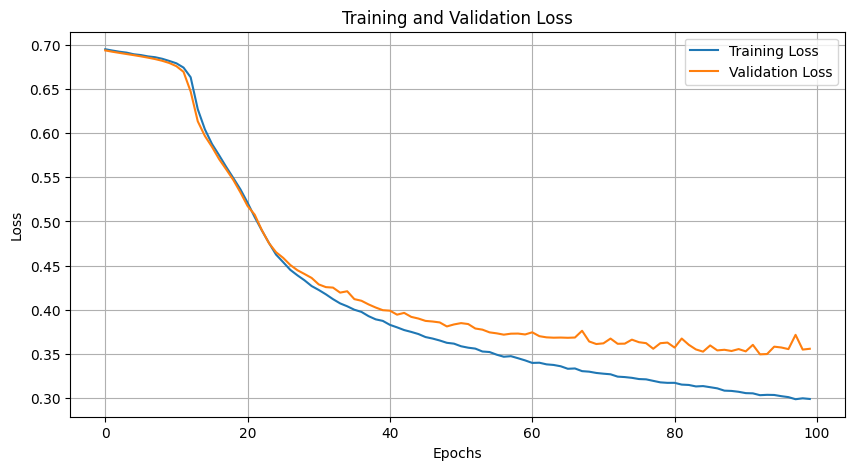

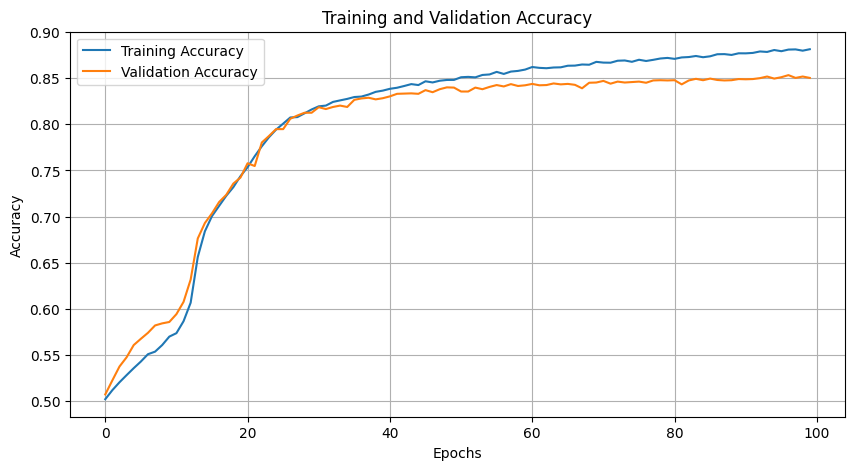

In [29]:

# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Take the last output
        x = self.dropout(lstm_out)  # Apply dropout
        x = self.fc(x)
        return self.sigmoid(x)

# Set hyperparameters
input_dim = frequentWord
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.00007
weight_decay = 7e-4
dropout = 0.55
batch_size = 512
num_epochs = 100

# Instantiate the model and move to device
model = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Training Loss: 0.2993, Validation Loss: 0.3560, 
#### Train Accuracy: 0.8813, Validation Accuracy: 0.8502, Test Accuracy: 0.8502
#### Compute Time: 50 seconds

# PREVIOUS ATTEMPTS

/tmp/ipykernel_2747/4167874320.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_2747/4167874320.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_2747/4167874320.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_2747/4167874320.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/100, Loss: 0.6958, Validation Loss: 0.6930, Train Accuracy: 0.5042, Validation Accuracy: 0.5152
Epoch 2/100, Loss: 0.6937, Validation Loss: 0.6913, Train Accuracy: 0.5124, Validation Accuracy: 0.5295
Epoch 3/100, Loss: 0.6924, Validation Loss: 0.6897, Train Accuracy: 0.5182, Validation Accuracy: 0.5377
Epoch 4/100, Loss: 0.6908, Validation Loss: 0.6882, Train Accuracy: 0.5272, Validation Accuracy: 0.5595
Epoch 5/100, Loss: 0.6892, Validation Loss: 0.6868, Train Accuracy: 0.5391, Validation Accuracy: 0.5680
Epoch 6/100, Loss: 0.6880, Validation Loss: 0.6853, Train Accuracy: 0.5448, Validation Accuracy: 0.5775
Epoch 7/100, Loss: 0.6862, Validation Loss: 0.6837, Train Accuracy: 0.5523, Validation Accuracy: 0.5805
Epoch 8/100, Loss: 0.6852, Validation Loss: 0.6821, Train Accuracy: 0.5564, Validation Accuracy: 0.5823
Epoch 9/100, Loss: 0.6833, Validation Loss: 0.6802, Train Accuracy: 0.5638, Validation Accuracy: 0.5885
Epoch 10/100, Loss: 0.6813, Validation Loss: 0.6780, Train Accur

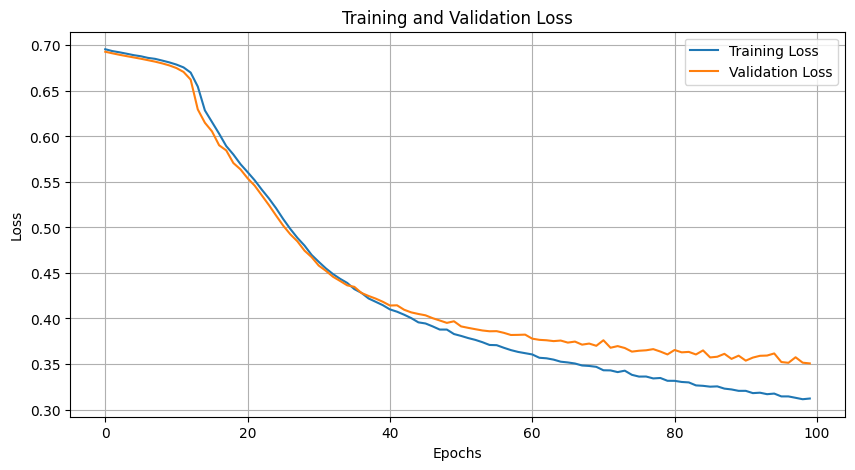

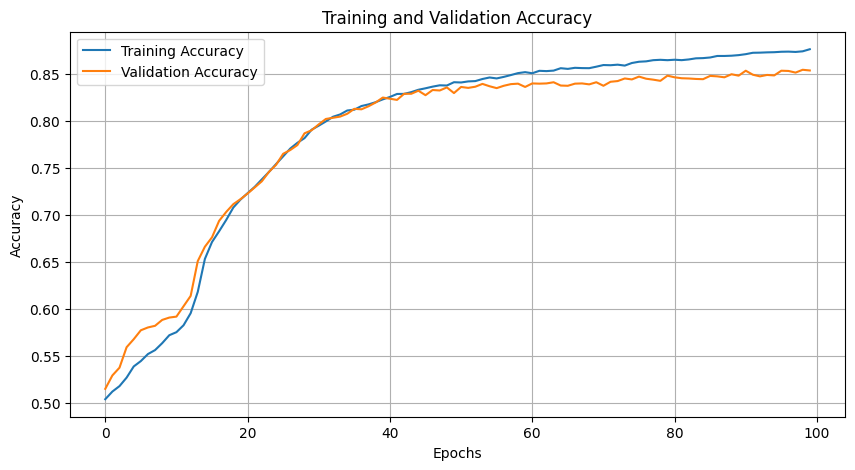

In [28]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Take the last output
        x = self.dropout(lstm_out)  # Apply dropout
        x = self.fc(x)
        return self.sigmoid(x)

# Set hyperparameters
input_dim = frequentWord
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.00006
weight_decay = 7e-4
dropout = 0.55
batch_size = 512
num_epochs = 100

# Instantiate the model and move to device
model = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_51/2690982991.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_51/2690982991.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_51/2690982991.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_51/2690982991.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 1/100, Loss: 0.6946, Validation Loss: 0.6931, Train Accuracy: 0.5023, Validation Accuracy: 0.5065
Epoch 2/100, Loss: 0.6931, Validation Loss: 0.6919, Train Accuracy: 0.5103, Validation Accuracy: 0.5170
Epoch 3/100, Loss: 0.6915, Validation Loss: 0.6907, Train Accuracy: 0.5205, Validation Accuracy: 0.5282
Epoch 4/100, Loss: 0.6904, Validation Loss: 0.6896, Train Accuracy: 0.5278, Validation Accuracy: 0.5377
Epoch 5/100, Loss: 0.6893, Validation Loss: 0.6884, Train Accuracy: 0.5377, Validation Accuracy: 0.5407
Epoch 6/100, Loss: 0.6881, Validation Loss: 0.6872, Train Accuracy: 0.5423, Validation Accuracy: 0.5480
Epoch 7/100, Loss: 0.6864, Validation Loss: 0.6859, Train Accuracy: 0.5483, Validation Accuracy: 0.5510
Epoch 8/100, Loss: 0.6853, Validation Loss: 0.6844, Train Accuracy: 0.5537, Validation Accuracy: 0.5590
Epoch 9/100, Loss: 0.6832, Validation Loss: 0.6826, Train Accuracy: 0.5615, Validation Accuracy: 0.5647
Epoch 10/100, Loss: 0.6809, Validation Loss: 0.6804, Train Accur

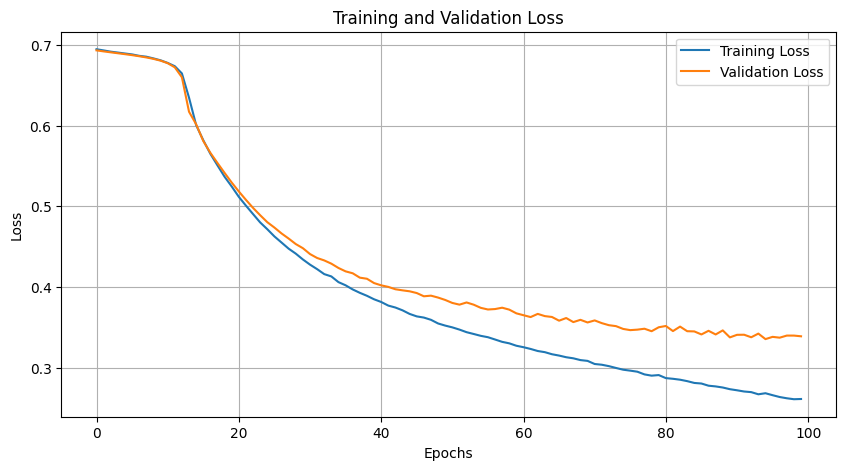

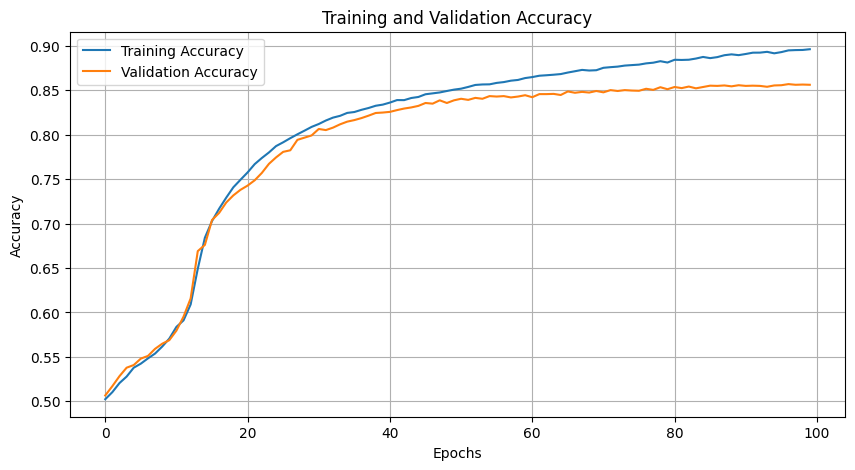

In [28]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Take the last output
        x = self.dropout(lstm_out)  # Apply dropout
        x = self.fc(x)
        return self.sigmoid(x)

# Set hyperparameters
input_dim = frequentWord
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.00005
weight_decay = 5e-5
dropout = 0.4
batch_size = 512
num_epochs = 100

# Instantiate the model and move to device
model = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_2747/2156486312.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_2747/2156486312.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_2747/2156486312.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_2747/2156486312.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/100, Loss: 0.6949, Validation Loss: 0.6933, Train Accuracy: 0.5012, Validation Accuracy: 0.5045
Epoch 2/100, Loss: 0.6929, Validation Loss: 0.6916, Train Accuracy: 0.5149, Validation Accuracy: 0.5215
Epoch 3/100, Loss: 0.6908, Validation Loss: 0.6900, Train Accuracy: 0.5291, Validation Accuracy: 0.5343
Epoch 4/100, Loss: 0.6892, Validation Loss: 0.6885, Train Accuracy: 0.5363, Validation Accuracy: 0.5417
Epoch 5/100, Loss: 0.6871, Validation Loss: 0.6868, Train Accuracy: 0.5447, Validation Accuracy: 0.5525
Epoch 6/100, Loss: 0.6849, Validation Loss: 0.6849, Train Accuracy: 0.5561, Validation Accuracy: 0.5577
Epoch 7/100, Loss: 0.6826, Validation Loss: 0.6824, Train Accuracy: 0.5655, Validation Accuracy: 0.5727
Epoch 8/100, Loss: 0.6790, Validation Loss: 0.6789, Train Accuracy: 0.5736, Validation Accuracy: 0.5700
Epoch 9/100, Loss: 0.6737, Validation Loss: 0.6720, Train Accuracy: 0.5826, Validation Accuracy: 0.5787
Epoch 10/100, Loss: 0.6590, Validation Loss: 0.6459, Train Accur

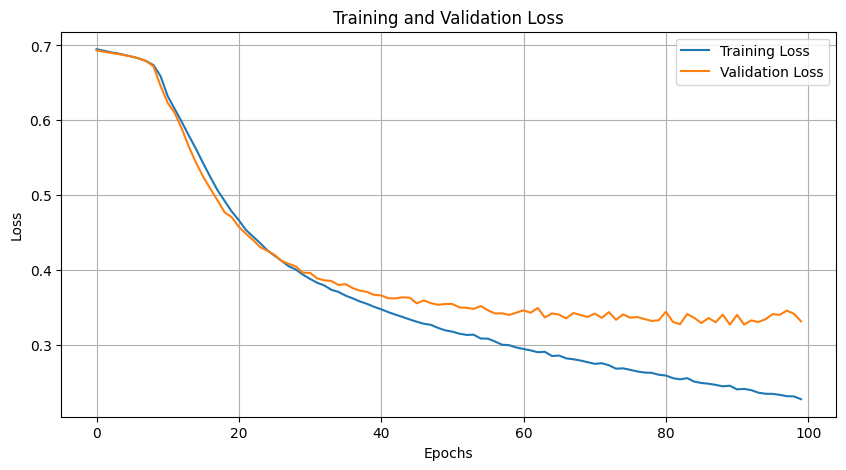

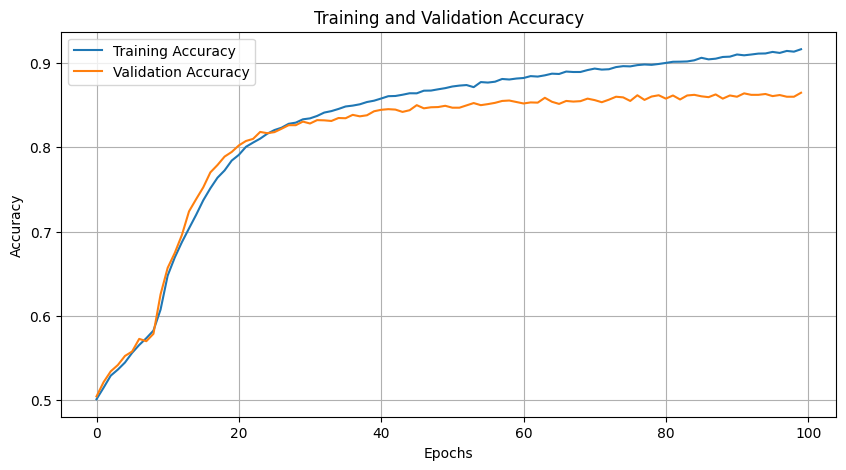

In [24]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Take the last output
        x = self.dropout(lstm_out)  # Apply dropout
        x = self.fc(x)
        return self.sigmoid(x)

# Set hyperparameters
input_dim = frequentWord
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.00008
weight_decay = 1e-4
dropout = 0.55
batch_size = 512
num_epochs = 100

# Instantiate the model and move to device
model = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_2747/4174948373.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_2747/4174948373.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_2747/4174948373.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_2747/4174948373.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/100, Loss: 0.6946, Validation Loss: 0.6935, Train Accuracy: 0.5045, Validation Accuracy: 0.5070
Epoch 2/100, Loss: 0.6936, Validation Loss: 0.6924, Train Accuracy: 0.5120, Validation Accuracy: 0.5128
Epoch 3/100, Loss: 0.6921, Validation Loss: 0.6914, Train Accuracy: 0.5219, Validation Accuracy: 0.5270
Epoch 4/100, Loss: 0.6913, Validation Loss: 0.6905, Train Accuracy: 0.5231, Validation Accuracy: 0.5385
Epoch 5/100, Loss: 0.6906, Validation Loss: 0.6896, Train Accuracy: 0.5281, Validation Accuracy: 0.5395
Epoch 6/100, Loss: 0.6889, Validation Loss: 0.6886, Train Accuracy: 0.5385, Validation Accuracy: 0.5403
Epoch 7/100, Loss: 0.6885, Validation Loss: 0.6877, Train Accuracy: 0.5412, Validation Accuracy: 0.5480
Epoch 8/100, Loss: 0.6875, Validation Loss: 0.6867, Train Accuracy: 0.5455, Validation Accuracy: 0.5507
Epoch 9/100, Loss: 0.6860, Validation Loss: 0.6856, Train Accuracy: 0.5516, Validation Accuracy: 0.5533
Epoch 10/100, Loss: 0.6850, Validation Loss: 0.6844, Train Accur

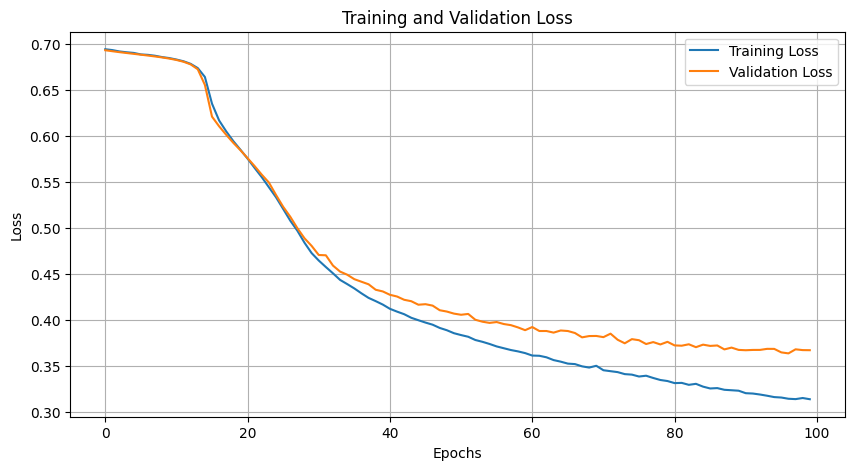

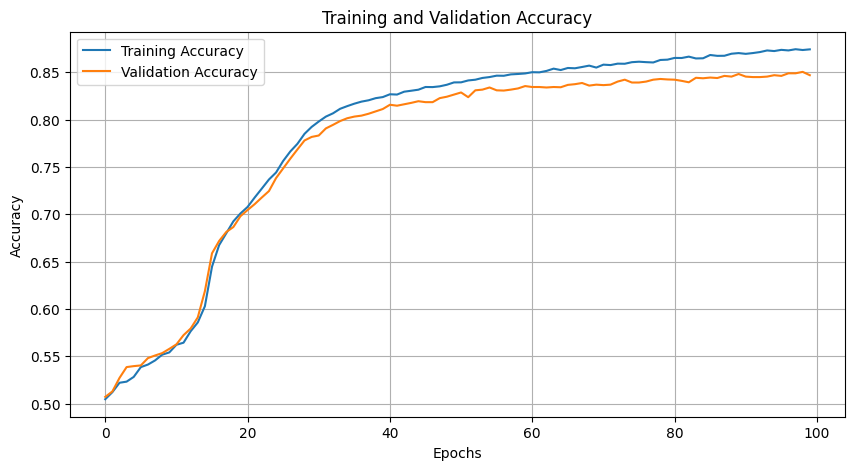

In [30]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Take the last output
        x = self.dropout(lstm_out)  # Apply dropout
        x = self.fc(x)
        return self.sigmoid(x)

# Set hyperparameters
input_dim = frequentWord
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.00006
weight_decay = 8e-4
dropout = 0.55
batch_size = 512
num_epochs = 100

# Instantiate the model and move to device
model = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_2747/3037741335.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_2747/3037741335.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_2747/3037741335.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_2747/3037741335.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/100, Loss: 0.6970, Validation Loss: 0.6939, Train Accuracy: 0.4996, Validation Accuracy: 0.5015
Epoch 2/100, Loss: 0.6945, Validation Loss: 0.6917, Train Accuracy: 0.5098, Validation Accuracy: 0.5145
Epoch 3/100, Loss: 0.6919, Validation Loss: 0.6898, Train Accuracy: 0.5226, Validation Accuracy: 0.5360
Epoch 4/100, Loss: 0.6901, Validation Loss: 0.6880, Train Accuracy: 0.5327, Validation Accuracy: 0.5483
Epoch 5/100, Loss: 0.6885, Validation Loss: 0.6862, Train Accuracy: 0.5416, Validation Accuracy: 0.5567
Epoch 6/100, Loss: 0.6855, Validation Loss: 0.6842, Train Accuracy: 0.5541, Validation Accuracy: 0.5715
Epoch 7/100, Loss: 0.6840, Validation Loss: 0.6819, Train Accuracy: 0.5617, Validation Accuracy: 0.5803
Epoch 8/100, Loss: 0.6816, Validation Loss: 0.6789, Train Accuracy: 0.5659, Validation Accuracy: 0.5897
Epoch 9/100, Loss: 0.6772, Validation Loss: 0.6742, Train Accuracy: 0.5837, Validation Accuracy: 0.5962
Epoch 10/100, Loss: 0.6713, Validation Loss: 0.6639, Train Accur

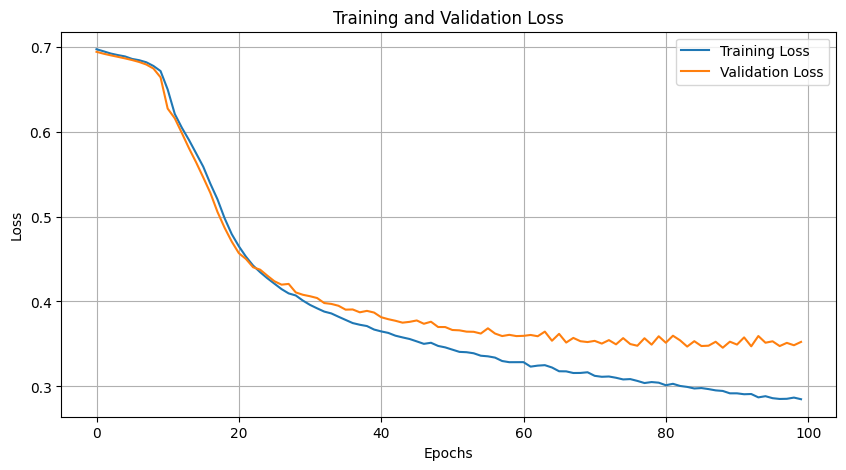

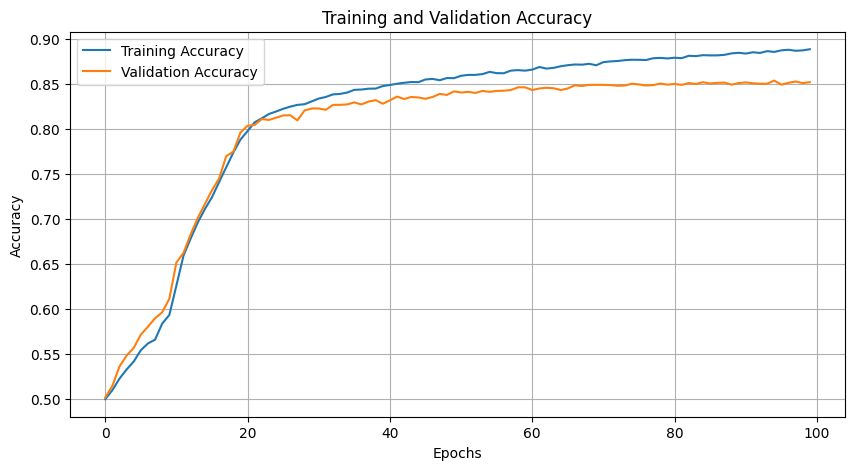

In [27]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Take the last output
        x = self.dropout(lstm_out)  # Apply dropout
        x = self.fc(x)
        return self.sigmoid(x)

# Set hyperparameters
input_dim = frequentWord
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.00008
weight_decay = 7e-4
dropout = 0.55
batch_size = 512
num_epochs = 100

# Instantiate the model and move to device
model = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()